# Probability of Improvement

This section describes another approach for performing balanced exploration and exploitation. The next infill point is obtained by maximizing the probability of improvement (PI) given as

$$
    PI(x) = P(\hat{f}(x) \leq f^*) = \Phi\left(\frac{f^* - \hat{f}(x)}{ \hat{\sigma}(x)}\right)
$$

where $\Phi$ is the cumulative distribution function of the standard normal distribution, $f^*$ is the best observed value, and $\hat{f}(x)$ and $\hat{\sigma}(x)$ are the prediction and standard deviation from surrogate model at $x$, respectively. The PI function is a measure of the probability that the improvement of surrogate model at $x$ over the best observed value is greater than zero. 

Below code imports required packages, defines modified branin function, and creates plotting data:

In [9]:
# Imports
import numpy as np
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from scipy.stats import norm as normal

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)

    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] )) 
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)

Differential evolution (DE) from `pymoo` is used for minimizing the surrogate model. Below code defines problem class and initializes DE. Note how problem class is using both prediction and uncertainty together.

In [10]:
# Problem class
class Surrogate(Problem):

    def __init__(self, sm, ymin):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model
        self.ymin = ymin

    def _evaluate(self, x, out, *args, **kwargs):

        numerator = self.ymin - self.sm.predict_values(x)
        denominator = np.sqrt( self.sm.predict_variances(x) ) # sigma
        
        # Computing probability of improvement
        out["F"] = - normal.cdf(numerator/denominator) # PI

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

Below block of code creates 5 training points and performs sequential sampling using PI. The maximum number of iterations is set to 20 and a convergence criterion is defined based on maximum value of PI obtained in each iteration.

In [11]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-2
max_PI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_PI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the best observed sample
    ybest.append(np.min(ytrain))

    # Find the minimum of surrogate model
    result = minimize(Surrogate(sm, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))
    
    # Storing variables
    if itr == 0:
        max_PI[0] = -result.F[0]
        xbest = xtrain[np.argmin(ytrain)].reshape(1,-1)
    else:
        max_PI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[np.argmin(ytrain)]))

    print("Maximum PI: {}".format(max_PI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))


Iteration 1
Maximum PI: 0.5307276253640137
Best observed value: -8.969989311850687

Iteration 2
Maximum PI: 1.0
Best observed value: -8.969989311850687

Iteration 3
Maximum PI: 1.0
Best observed value: -10.539622928100016

Iteration 4
Maximum PI: 1.0
Best observed value: -10.548222713569086

Iteration 5
Maximum PI: 1.0
Best observed value: -10.811096859780191

Iteration 6
Maximum PI: 1.0
Best observed value: -10.846424691094906

Iteration 7
Maximum PI: 0.9999999823974798
Best observed value: -10.846586669519857

Iteration 8
Maximum PI: 1.0
Best observed value: -11.370843631821975

Iteration 9
Maximum PI: 1.0
Best observed value: -12.62827813750655

Iteration 10
Maximum PI: 1.0
Best observed value: -12.930375341448068

Iteration 11
Maximum PI: 1.0
Best observed value: -12.934593556882668

Iteration 12
Maximum PI: 1.0
Best observed value: -13.879940903713123

Iteration 13
Maximum PI: 1.0
Best observed value: -15.106508885431069

Iteration 14
Maximum PI: 1.0
Best observed value: -16.0083

Below code plots the convergence of best observed value and PI.

Text(0.5, 0.98, 'Probability of Improvement')

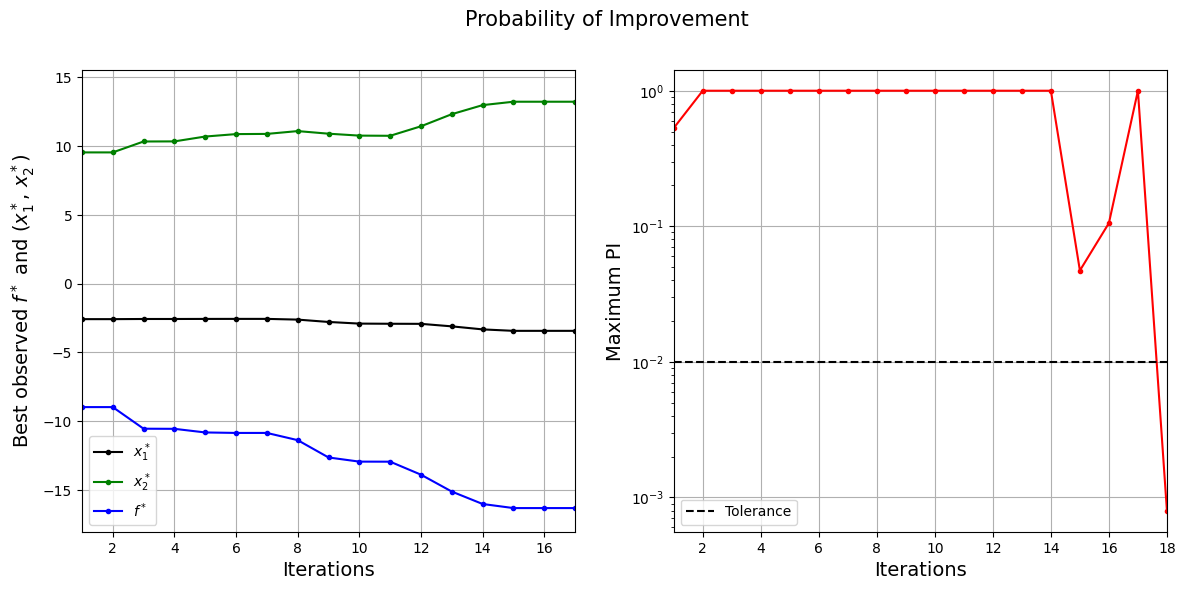

In [13]:
####################################### Plotting convergence history

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(np.arange(itr) + 1, xbest[:,0], c="black", label='$x_1^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, xbest[:,1], c="green", label='$x_2^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, ybest, c="blue", label='$f^*$', marker=".")
ax[0].set_xlabel("Iterations", fontsize=14)
ax[0].set_ylabel("Best observed $f^*$ and ($x_1^*$, $x_2^*$)", fontsize=14)
ax[0].legend()
ax[0].set_xlim(left=1, right=itr-1)
ax[0].grid()

ax[1].plot(np.arange(itr) + 1, max_PI, c="red", marker=".")
ax[1].plot(np.arange(itr) + 1, [tol]*(itr), c="black", linestyle="--", label="Tolerance")
ax[1].set_xlabel("Iterations", fontsize=14)
ax[1].set_ylabel("Maximum PI", fontsize=14)
ax[1].set_xlim(left=1, right=itr)
ax[1].grid()
ax[1].legend()
ax[1].set_yscale("log")

fig.suptitle("Probability of Improvement", fontsize=15)

The figure on left shows the history of best observed $y$ value and corresponding $x$ values, and figure on right shows the convergence of PI. At the start, the PI is high since the possibility to find a better point is high. As the iterations progress, the best observed value reaches the global minimum and the PI decreases since there is less possibility to find a better point.

Below code plots the infill points.

Text(0.5, 1.0, 'Modified Branin function')

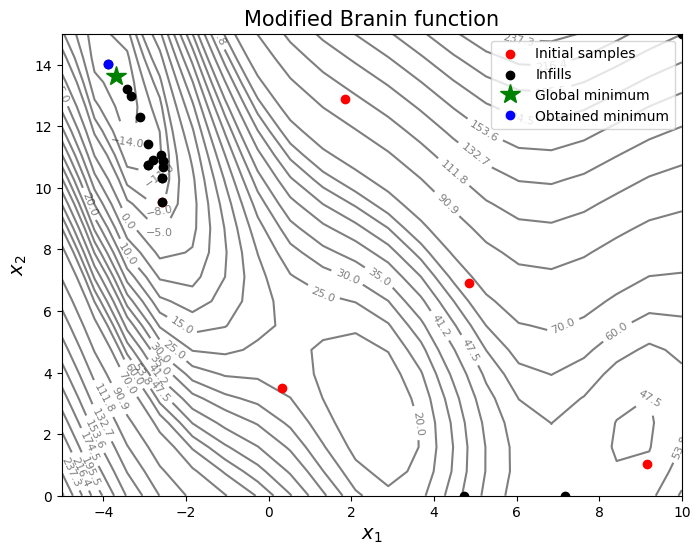

In [14]:
####################################### Plotting initial samples and infills

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.plot(-3.689, 13.630, 'g*', markersize=15, label="Global minimum")
ax.plot(xbest[-1,0], xbest[-1,1], 'bo', label="Obtained minimum")
ax.legend()
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Modified Branin function", fontsize=15)

Based on the infills, PI seems to be slightly more biased towards adding points close to the minimum values in the dataset - less exploration and more exploitation - and there is no way to control that through the criteria itself. As discussed in the lecture, PI provides only a probability value and doesn't quantify the amount of improvement.

> __*NOTE*__: Due to randomness in differential evolution, results may vary slightly between runs. So, it is recommended to run the code multiple times to see average behavior.

Final result:

| Parameter         | True minimum | Obtained minimum|
|-------------------|--------------|-----------------|
| $x_1^*$           | -3.689       | -3.876          |
| $x_2^*$           | 13.630       | 14.011          |
| $f(x_1^*, x_2^*)$ | -16.644      | -16.497         |